In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [3]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [4]:
# Reading channels
data = Data[4]
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [5]:
# Para el caso 1 canal
data = pd.read_csv('Data/1Channel.csv',sep=',')
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [6]:
def Gauss(x,mean=1.,sigma=0.1):
    return norm.pdf(x,loc=mean,scale=sigma)

In [7]:
# p is for the nuissance parameters
def LogLikelihood(p,mu,n,b,s):

    e = p
    
    r = 1e-5
    lambda_ = mu*s + e*b + r
    
    log_likelihood = -lambda_ + n * np.log(lambda_) - gammaln(n+1)
    
    return log_likelihood

In [8]:
def GetJointLogLikelihood(p,mu,n,b,s):

    e = p
    JointLog = 0.
    
    for c in range(N):

        sigmab = 0.1
        
        JointLog += LogLikelihood(p,mu,n[c],b[c],s[c])
        JointLog += np.log(Gauss(e,1.,sigmab))
            
    return -2.*JointLog

In [9]:
mu = np.linspace(0.05,3.,20)
LogLike = GetJointLogLikelihood(1.03,mu,n,b,s)
LogLike1 = GetJointLogLikelihood(1.,mu,n,b,s)

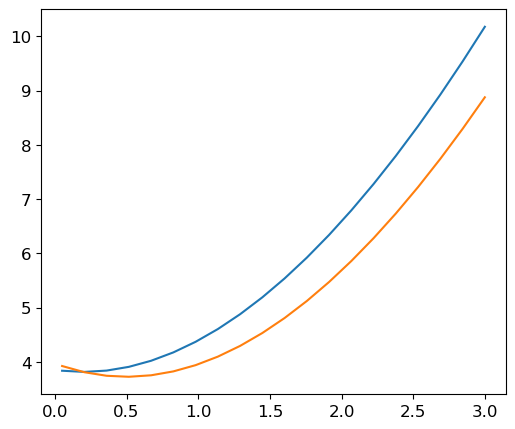

In [10]:
plt.plot(mu,LogLike)
plt.plot(mu,LogLike1)

In [11]:
# Vamos hacer el scanpara encontrar el double hat e
def GetProfile(mu):

    doublehat = np.zeros_like(mu)
    p0 = [0.5]
    
    for i in range(len(mu)):
        bounds =  ((0,10),)
        result = spo.minimize( GetJointLogLikelihood, p0, args=(mu[i],n,b,s), bounds=bounds, options={"disp":False}, method='Nelder-Mead' )
        doublehat[i] = result.x[0]

    return doublehat

In [12]:
doublehat = GetProfile(mu)

In [13]:
def Profile(mu,n,b,s,sigma = 0.1):
    perfil = ( ( b[0] - mu*s[0] - (b[0]*sigma)**2) + np.sqrt( ( b[0] + mu*s[0] - (b[0]*sigma)**2)**2 + 4*(b[0]*sigma)**2*n[0] ))/ (2*b[0])
    return perfil

In [14]:
Exact = Profile(mu,n,b,s)

In [16]:
Exact

array([1.02219813, 1.01448331, 1.00682731, 0.99923009, 0.99169162,
       0.98421188, 0.9767908 , 0.96942834, 0.96212442, 0.95487896,
       0.94769188, 0.94056308, 0.93349245, 0.92647987, 0.91952522,
       0.91262836, 0.90578914, 0.89900741, 0.89228301, 0.88561576])

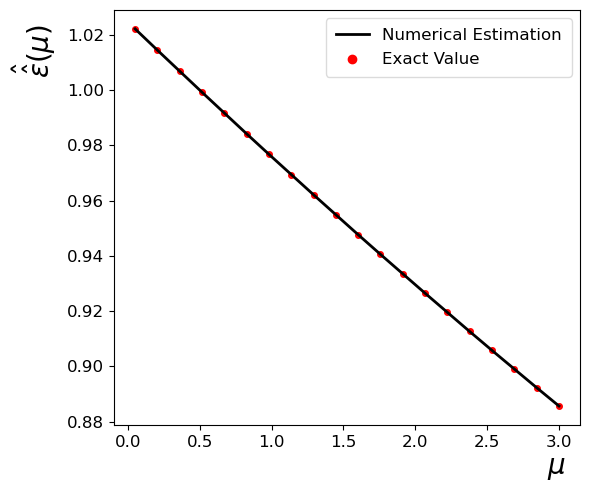

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(mu,doublehat,color='k',lw=2,label='Numerical Estimation')
ax.scatter(mu,Exact,color='r',marker='o',label='Exact Value')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$\hat{\hat{\epsilon}}(\mu)$')
ax.yaxis.set_label_coords(-0.12,0.90)

#ax.set_yscale('log')

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('DoubleHat.pdf')